# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
#%matplotlib inline

import torch
torch.manual_seed(100) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import time

plt.ion()

In [27]:
env = gym.make('CartPole-v0')
env.seed(100)

state_space_size = len(env.observation_space.high)
action_space_size = env.action_space.n

print(state_space_size)
print(action_space_size)

4
2


In [3]:
torch.tanh()

TypeError: tanh(): argument 'input' (position 1) must be Tensor, not int

### 2. Define the Architecture of the Policy

In [29]:

# todo: move this to separate file
class Policy(nn.Module):
    # we define the policy as a simple neural net
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

### 3. Train the Agent with REINFORCE

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=5000, max_t=1000, gamma=0.999, print_every=200):
    scores_deque = deque(maxlen=150)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=200.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.state_dict(), 'checkpoint.pth')
            break
        
    return scores

In [36]:
print(f"start_time: {time.ctime()}\n")
scores = reinforce()
print(f"\nend time_time: {time.ctime()}")


start_time: Fri Aug 28 06:44:17 2020

Episode 200	Average Score: 32.39
Episode 400	Average Score: 46.17
Episode 600	Average Score: 83.79
Episode 800	Average Score: 129.60
Episode 1000	Average Score: 167.59
Episode 1200	Average Score: 172.45
Environment solved in 1264 episodes!	Average Score: 200.00

end time_time: Fri Aug 28 06:45:47 2020


### 4. Plot the Scores

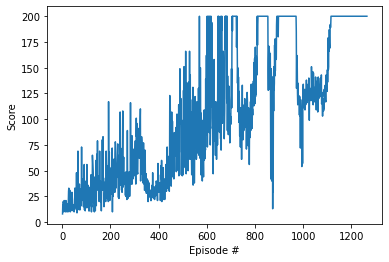

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

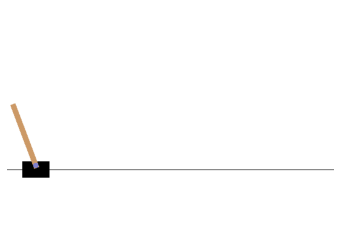

In [44]:
env = gym.make('CartPole-v0')
env.seed(55)
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

for t in range(200):
    action = env.action_space.sample()
    #action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    state, reward, done, _ = env.step(action)
    if done:
        pass
        #break 

env.close()